## Authors EDA
Exploratory data analysis focused on authors.

In [1]:
import pandas as pd
from matplotlib import pyplot as plt 
import numpy as np

%matplotlib inline

In [2]:
%%time

# load metadata extracted data in notebook 00_load_metadata
# parse the author_parsed entries into a list of authors for each paper
arxiv_metadata = pd.read_csv('data/arxiv_metadata.zip', converters={"authors_parsed": lambda x:[entry.strip('[]') for entry in  x.split("], ")]})

<timed exec>:3: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.


CPU times: user 12 s, sys: 1.72 s, total: 13.7 s
Wall time: 14.7 s


### Count unique authors
Take the list of "authors_parsed" for each paper. Flatten it. Remove duplicates.

In [3]:
def flatten(xss):
    """Flatten a list of lists"""
    return [x for xs in xss for x in xs]

def get_unique_authors(df):
    """Given a dataframe, return unique authors"""
    authors = flatten(df['authors_parsed'])
    return set(authors)

def count_authors(df):
    """Given a dataframe, return count of unique authors"""
    return len(get_unique_authors(df))

In [4]:
# ALL AUTHORS
count_all_authors = count_authors(arxiv_metadata)

# PUBLISHED AUTHORS
idx = arxiv_metadata['journal-ref'].isna()
arxiv_published = arxiv_metadata[~idx]
count_published_authors = count_authors(arxiv_published)

pd.DataFrame.from_dict(
    {'All authors': count_all_authors, 'Published authors': count_published_authors}, orient='index', columns=["Count"])

,Count
All authors,1978157
Published authors,897392


### Authors by subject

1. Make a dict of papers by subject, if a paper has several subjects, then that's several entries.
2. For each subject, take the count unique authors

In [5]:
keys = ["Computer Science", "Economics", "Electrical Engineering and Systems Science", "Mathematics", "Physics", "Quantitative Biology", "Quantitative Finance", "Statistics", "Junk"]

In [6]:
def count_authors_by_subject(df):
    # Make a dict of papers by subject (a DataFrame for each subject), if a paper has several subjects, then that paper will be in multiple DataFrames.
    papers_by_subject = {key: [] for key in keys}
    for key in keys:
        idx = df[key] == 1
        papers_by_subject[key] = df[idx]
    
    # For each subject, take the count unique authors
    return {key: count_authors(papers_by_subject[key]) for key in keys}

count_all_authors_by_subject = count_authors_by_subject(arxiv_metadata)
count_published_authors_by_subject = count_authors_by_subject(arxiv_published)
authors_by_subject = pd.DataFrame.from_records([count_all_authors_by_subject, count_published_authors_by_subject], index=['All papers', 'Published papers'])
# Rotate the DataFrame
authors_by_subject = authors_by_subject.T
authors_by_subject = authors_by_subject.sort_values('Published papers', ascending=False)
authors_by_subject

,All papers,Published papers
Physics,1095270,637334
Computer Science,1026274,357817
Mathematics,314410,108779
Statistics,143716,33046
Quantitative Biology,98071,29316
Electrical Engineering and Systems Science,150168,27723
Quantitative Finance,25180,5696
Economics,14566,2178
Junk,3617,680


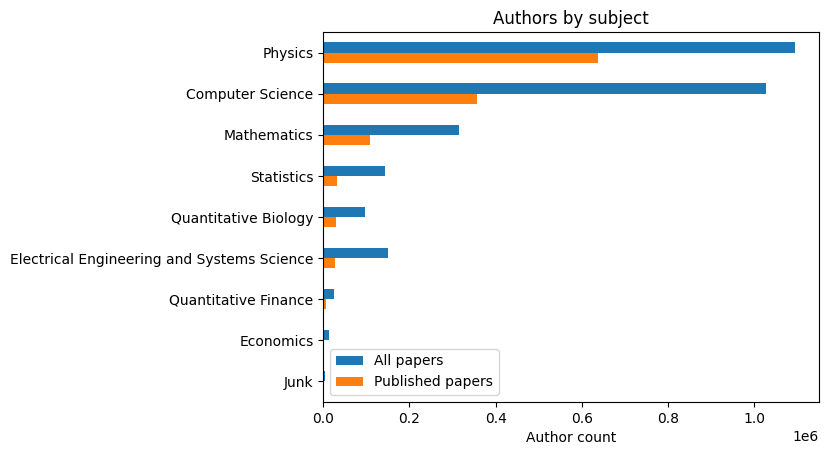

In [7]:
bar_plot = authors_by_subject.plot.barh()
bar_plot.set_title('Authors by subject')
bar_plot.set_xlabel('Author count')
bar_plot.invert_yaxis()
plt.show();

### Authors over time

#### Cumulative number of authors 

* keep only papers 1992 - 2023, as older years are incomplete
* Group papers by year and month
* For each year-month group, count unique authors

In [8]:
# keep only papers 1992 - 2023, as older years are incomplete
min_year = 1992  # arxiv_metadata.year.min()
max_year = 2023  # arxiv_metadata.year.max()

In [17]:
def group_papers_by_year_month(df):
    # Group papers by year and month
    df = df[(df['year'] >= min_year)]
    df = df[(df['year'] <= max_year)]
    return df.groupby([df.year, df.month])

In [18]:
def count_authors_by_year_month(df):
    papers_all_by_year_month = group_papers_by_year_month(df)
    # For each year-month group, count unique authors
    count_unique_authors = pd.DataFrame(columns=['year', 'month', 'count'])
    year = []; month = []; authors_count = []
    for entry in papers_all_by_year_month:
        entry_year = entry[0][0]
        year.append(entry_year)
        entry_month = entry[0][1]
        month.append(entry_month)
        entry_count = count_authors(entry[1])
        authors_count.append(entry_count)
    count_unique_authors['year'] = year
    count_unique_authors['month'] = month
    count_unique_authors['count'] = authors_count
    return count_unique_authors

In [28]:
count_all_authors_by_year_month = count_authors_by_year_month(arxiv_metadata)
count_published_authors_by_year_month = count_authors_by_year_month(arxiv_published)

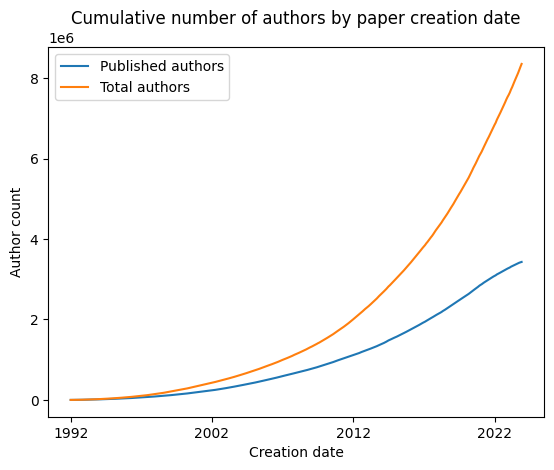

In [29]:
plt.title('Cumulative number of authors by paper creation date')
plt.xticks(ticks=range(0, len(count_published_authors_by_year_month), 120), labels=range(min_year, max_year+1, 10))
plt.xlabel('Creation date')
plt.ylabel('Author count')
plt.plot(np.cumsum(list(count_published_authors_by_year_month['count'])), label='Published authors')
plt.plot(np.cumsum(list(count_all_authors_by_year_month['count'])), label='Total authors')
plt.legend()
plt.show();

### Monthly number of authors by paper creation date

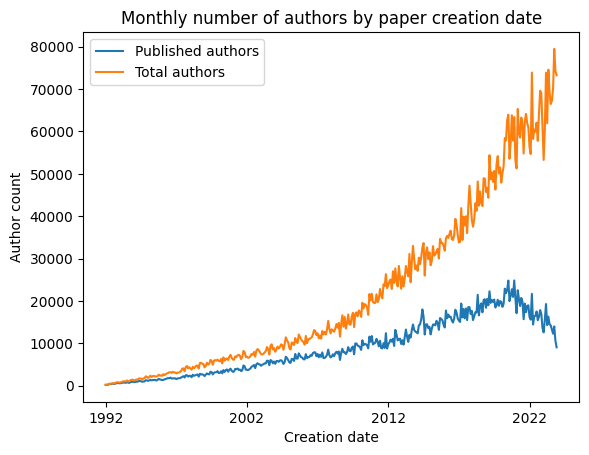

In [31]:
plt.title('Monthly number of authors by paper creation date')
plt.xticks(ticks=range(0, len(count_published_authors_by_year_month), 120), labels=range(min_year, max_year+1, 10))
plt.xlabel('Creation date')
plt.ylabel('Author count')
plt.plot(list(count_published_authors_by_year_month['count']), label='Published authors')
plt.plot(list(count_all_authors_by_year_month['count']), label='Total authors')
plt.legend()
plt.show();